In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score
import matplotlib.pyplot as plt
import scikitplot as skplt

In [14]:
df = pd.read_csv('./data/CellPhone_train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Análisis

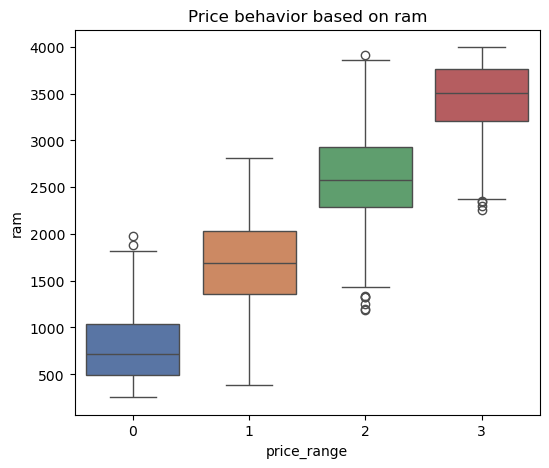

In [15]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df,x='price_range',hue='price_range',y='ram', palette='deep',legend=False)
plt.title("Price behavior based on ram")
plt.savefig("./images/pricevsram.png")
plt.show()

In [16]:
df.corr()['price_range']

battery_power    0.200723
blue             0.020573
clock_speed     -0.006606
dual_sim         0.017444
fc               0.021998
four_g           0.014772
int_memory       0.044435
m_dep            0.000853
mobile_wt       -0.030302
n_cores          0.004399
pc               0.033599
px_height        0.148858
px_width         0.165818
ram              0.917046
sc_h             0.022986
sc_w             0.038711
talk_time        0.021859
three_g          0.023611
touch_screen    -0.030411
wifi             0.018785
price_range      1.000000
Name: price_range, dtype: float64

## Modelado

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:,'battery_power':'wifi'],df['price_range'],test_size=0.33,random_state=42)

### Decission Tree Classifier

In [18]:
params_dtc = {
            'max_depth':np.arange(1,11).tolist(),
            'min_samples_leaf':np.arange(10,21).tolist(),
            'max_leaf_nodes':np.arange(10,21).tolist()
            }

In [19]:
grid_dtc = GridSearchCV(DecisionTreeClassifier(),params_dtc,cv=10,n_jobs=-1)
grid_dtc.fit(X_train,Y_train)

for k,v in grid_dtc.best_params_.items():
    print(f'Best param for {k}: {v}')

Best param for max_depth: 5
Best param for max_leaf_nodes: 20
Best param for min_samples_leaf: 10


In [20]:
dtc = DecisionTreeClassifier(
                                max_depth=grid_dtc.best_params_['max_depth'],
                                min_samples_leaf=grid_dtc.best_params_['min_samples_leaf'],
                                max_leaf_nodes=grid_dtc.best_params_['max_leaf_nodes']
                            )
dtc.fit(X_train,Y_train)
dtc.score(X_test,Y_test)

0.7924242424242425

In [21]:
y_dtc = dtc.predict(X_test)

### Random Forest

In [22]:
params_rfc = {
            'max_depth': [30, 40,50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_leaf_nodes': [10,20,30]
            }

Best params search

In [23]:
grid_rfc = GridSearchCV(RandomForestClassifier(),params_rfc,cv=10,n_jobs=-1)
grid_rfc.fit(X_train,Y_train)

for k,v in grid_rfc.best_params_.items():
    print(f'Best param for {k}: {v}')

Best param for max_depth: 40
Best param for max_leaf_nodes: 30
Best param for min_samples_leaf: 4
Best param for min_samples_split: 2


In [24]:
rfc = RandomForestClassifier(
                                max_features='sqrt',
                                n_estimators=200,
                                max_depth=grid_rfc.best_params_['max_depth'],
                                min_samples_split=grid_rfc.best_params_['min_samples_split'],
                                min_samples_leaf=grid_rfc.best_params_['min_samples_leaf'],
                                max_leaf_nodes=grid_rfc.best_params_['max_leaf_nodes'],
                                bootstrap=False,
                                random_state=123
                            )

rfc.fit(X_train,Y_train)
round(rfc.score(X_test,Y_test),3)

0.874

In [25]:
y_rfc = rfc.predict(X_test)

### KNeighbors Classifier

In [26]:
param_knc = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'leaf_size': [10, 20, 30, 40, 50]
}

In [27]:
grid_knc = GridSearchCV(KNeighborsClassifier(),param_knc,cv=10,n_jobs=-1)
grid_knc.fit(X_train,Y_train)

for k,v in grid_knc.best_params_.items():
    print(f'Best param for {k}: {v}')

Best param for algorithm: auto
Best param for leaf_size: 10
Best param for n_neighbors: 9
Best param for p: 2
Best param for weights: uniform


In [28]:
knc = KNeighborsClassifier(
                            algorithm=grid_knc.best_params_['algorithm'],
                            leaf_size=grid_knc.best_params_['leaf_size'],
                            n_neighbors=grid_knc.best_params_['n_neighbors'],
                            p=grid_knc.best_params_['p'],
                            weights=grid_knc.best_params_['weights']
                          )
knc.fit(X_train,Y_train)
knc.score(X_test,Y_test)

0.9363636363636364

In [29]:
y_knc = knc.predict(X_test)

### XGBoost Classifier

In [30]:
param_xgbc = {
    'n_estimators': [200,300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3],
    'gamma': [0.2, 0.3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [31]:
grid_xgbc = GridSearchCV(XGBClassifier(),param_xgbc,cv=10,n_jobs=-1)
grid_xgbc.fit(X_train,Y_train)

for k,v in grid_xgbc.best_params_.items():
    print(f'Best param for {k}: {v}')

Best param for colsample_bytree: 1.0
Best param for gamma: 0.3
Best param for learning_rate: 0.1
Best param for max_depth: 5
Best param for min_child_weight: 1
Best param for n_estimators: 300
Best param for subsample: 0.6


In [32]:
xgbc = XGBClassifier(
                        colsample_bytree=grid_xgbc.best_params_['colsample_bytree'],
                        gamma=grid_xgbc.best_params_['gamma'],
                        learning_rate=grid_xgbc.best_params_['learning_rate'],
                        max_depth=grid_xgbc.best_params_['max_depth'],
                        min_child_weight=grid_xgbc.best_params_['min_child_weight'],
                        n_estimators=grid_xgbc.best_params_['n_estimators'],
                        subsample=grid_xgbc.best_params_['subsample'],
                    )
xgbc.fit(X_train,Y_train)
round(dtc.score(X_test,Y_test),3)

0.792

In [33]:
y_xgbc = xgbc.predict(X_test)

### Adaboost Classifier

In [34]:
param_abc = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': np.linspace(0.01, 0.5, 50),
    'algorithm': ['SAMME', 'SAMME.R']
}

In [35]:
# abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=50,algorithm='SAMME',learning_rate=0.32)
abc = AdaBoostClassifier(SVC(C=10,kernel='linear'),n_estimators=50,algorithm='SAMME',learning_rate=0.32)
abc.fit(X_train,Y_train)
abc.score(X_test,Y_test)

0.9681818181818181

In [36]:
y_abc = abc.predict(X_test)

# Comparación de precisión de modelos

In [37]:


print(f"Decision Tree Classifier: {round(dtc.score(X_test,Y_test),3)}")
print(f"Random Forest Classifier: {round(rfc.score(X_test,Y_test),3)}")
print(f"KNeighbors Classifier:    {round(knc.score(X_test,Y_test),3)}")
print(f"XGBoost Classifier:       {round(xgbc.score(X_test,Y_test),3)}")
print(f"Adaboost Classifier:      {round(abc.score(X_test,Y_test),3)}")

Decision Tree Classifier: 0.792
Random Forest Classifier: 0.874
KNeighbors Classifier:    0.936
XGBoost Classifier:       0.912
Adaboost Classifier:      0.968


In [38]:
pd.DataFrame({"Modelo":["Decision Tree Classifier","Random Forest Classifier","KNeighbors Classifier","XGboost Classifier","AdaBoost Classifier"],
              "Accuracy":[round(accuracy_score(Y_test,y_dtc),3),round(accuracy_score(Y_test,y_rfc),3),round(accuracy_score(Y_test,y_knc),3),round(accuracy_score(Y_test,y_xgbc),3),round(accuracy_score(Y_test,y_abc),3)],
              "F1 score":[round(f1_score(Y_test,y_dtc,average='weighted'),3),round(f1_score(Y_test,y_rfc,average='weighted'),3),round(f1_score(Y_test,y_knc,average='weighted'),3),round(f1_score(Y_test,y_xgbc,average='weighted'),3),round(f1_score(Y_test,y_abc,average='weighted'),3)]})

,Modelo,Accuracy,F1 score
0,Decision Tree Classifier,0.792,0.794
1,Random Forest Classifier,0.874,0.873
2,KNeighbors Classifier,0.936,0.936
3,XGboost Classifier,0.912,0.912
4,AdaBoost Classifier,0.968,0.968


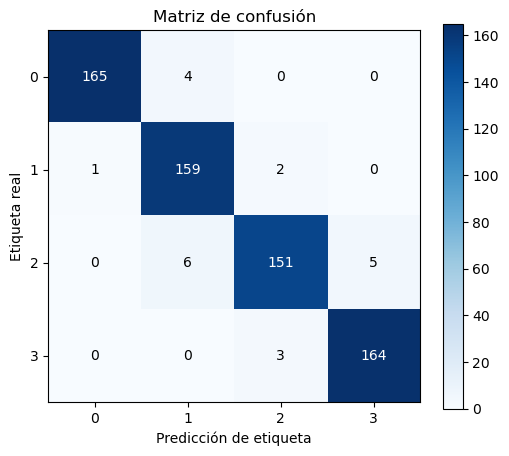

In [48]:
# plt.figure(figsize=(5,6))
skplt.metrics.plot_confusion_matrix(Y_test,y_abc,figsize=(6,5))
plt.title("Matriz de confusión")
plt.ylabel('Etiqueta real')
plt.xlabel('Predicción de etiqueta')
plt.savefig("./images/confussionmatrix.png")
plt.show()